In [ ]:
print("Training notebook")

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls

gdrive	sample_data


In [ ]:
%cd /content/gdrive/MyDrive/Inception_time/InceptionTime/

/content/gdrive/MyDrive/Inception_time/InceptionTime


In [ ]:
!pwd

/content/gdrive/MyDrive/Inception_time/InceptionTime


In [ ]:
import sys
sys.path.append("./")
from utils import utils

In [ ]:
from main import *

In [ ]:
!pip install tslearn

     |████████████████████████████████| 798kB 6.8MB/s 


In [ ]:
!python3 main.py -i /content/gdrive/MyDrive/Inception_time/InceptionTime/archives/UCR_TS_Archive_2015 -d /content/gdrive/MyDrive/Inception_time/InceptionTime/MixUp_results/20210712_test -a GROUPED_TSC -p 5 --mixup True -g True

Traceback (most recent call last):
  File "main.py", line 25, in <module>
    import classifiers 
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 963, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 906, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1280, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1252, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1364, in find_spec
  File "<frozen importlib._bootstrap_external>", line 81, in _path_stat
KeyboardInterrupt


In [ ]:
for i in range(17):
  !python3 main.py -d /content/gdrive/MyDrive/Inception_time/InceptionTime/MixUp_results/20210712_test -a GROUPED_TSC -p i --mixup True -g True

# DTW MIX

In [ ]:
root_dir = '/content/gdrive/MyDrive/Inception_time/InceptionTime/archives/UCR_TS_Archive_2015'

In [ ]:
def prepare_data(datasets_dict, dataset_name):
    x_train = datasets_dict[dataset_name][0]
    y_train = datasets_dict[dataset_name][1]
    x_test = datasets_dict[dataset_name][2]
    y_test = datasets_dict[dataset_name][3]

    nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))

    # make the min to zero of labels
    y_train, y_test = transform_labels(y_train, y_test)

    # save orignal y because later we will use binary
    y_true = y_test.astype(np.int64)
    y_true_train = y_train.astype(np.int64)
    # transform the labels from integers to one hot vectors
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
    y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    
    if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        x_train = np.array(x_train)
        x_test = np.array(x_test)
    
    x_train = torch.from_numpy(x_train)
    x_test = torch.from_numpy(x_test)
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)
    y_true = torch.from_numpy(y_true)

    
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_true, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size= 64, shuffle=True, num_workers= 0)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers= 0)
   
    #return train_dataloader, test_dataloader, nb_classes, y_true, enc
    return x_train, y_train, x_test, y_test, nb_classes, y_true, enc

In [ ]:
archive_name = 'TSC'
datasets_dict = read_all_datasets(root_dir, archive_name)
DATASET_NAMES = ['Herring']
for dataset_name in DATASET_NAMES:
  #x_train, y_train, *_ = prepare_data(datasets_dict, dataset_name)
  x_train, y_train, x_test, y_test, nb_classes, y_true, enc = prepare_data(datasets_dict, dataset_name)

In [ ]:
x_train.shape

torch.Size([64, 512, 1])

In [ ]:
#!/home/ych/anaconda3/bin/python
# -*- coding: utf-8 -*-

# inspired by https://github.com/pierre-rouanet/dtw

import numpy as np

def distance(x, y):
    return (x - y) * (x - y)

def dynamic_time_warping(x, y, distance=distance, window_size=1.0):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array.
    :param array y: N2*M array.
    :param func dist_fun: distance used as cost measure.
    :param float window_size: window size limiting the maximal distance.
    Returns the cost matrix, the accumulated cost, the minumum distance, and the wrap path.
    """

    assert len(x), 'the length of x is smaller than 1'
    assert len(y), 'the length of x is smaller than 1'
    assert int(len(x) * window_size) >= abs(len(x) - len(y)), 'the window size is smaller than the abs of x and y'
    
    lx, ly = len(x), len(y)
    r, c = lx + 1, ly + 1
    w = int(len(x) * window_size)

    #print('x-len = {r} \ny-len = {c}'.format(r=r,c=c))

    if window_size != 1.0:
        D = np.full((r, c), np.inf)
        for i in range(1, r):
            D[i, max(1, i - w): min(c, i + w + 1)] = 0
        D[0, 0] = 0
    else:
        D = np.zeros((r, c), dtype=np.float64)
        D[0, 1:] = np.inf
        D[1:, 0] = np.inf

    # 浅拷贝
    D_copy = D[1:, 1:]
    # 原始的距离矩阵
    for i in range(lx):
        for j in range(ly):
            if (window_size == 1.0 or max(0, i - w) <= j <= min(ly, i + w)):
                D_copy[i, j] = distance(x[i], y[j])
    # 深拷贝
    C = D_copy.copy()
    jrange = range(ly)
    # 动态计算最短路径
    for i in range(lx):
        if window_size != 1.0:
            jrange = range(max(0, i - w), min(ly, i + w +1))
        for j in jrange:
            D_copy[i, j] += min(D[i, j], D[i, j + 1], D[i + 1, j])

    # 计算后的距离矩阵的[-2, -2]位置的下标
    i, j = np.array(D.shape) - 2
    p, q = [i], [j]
    # 从后往前推算路径
    while i > 0 or j > 0:
        tb = np.argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else: # tb == 2
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    
    return C, D_copy, D_copy[-1, -1], list(zip(p, q))
    

if __name__ == '__main__':
    x = [0, 0, 1, 1, 2, 4, 2, 1, 2, 0]
    y = [1, 1, 1, 2, 2, 2, 2, 3, 2, 0]
    window_size = 1.0
    # x = [1,2,3,4,5,5,5,4]
    # y = [3,4,5,5,5,4]
    x = [0,1,2,2,2,1]
    y = [1,1,2,3,1,0]
    D_original, D_calculated, dist, path = dynamic_time_warping(x, y, distance, window_size)
    print(D_original)
    print(D_calculated)
    print(path)

[[1. 1. 4. 9. 1. 0.]
 [0. 0. 1. 4. 0. 1.]
 [1. 1. 0. 1. 1. 4.]
 [1. 1. 0. 1. 1. 4.]
 [1. 1. 0. 1. 1. 4.]
 [0. 0. 1. 4. 0. 1.]]
[[ 1.  2.  6. 15. 16. 16.]
 [ 1.  1.  2.  6.  6.  7.]
 [ 2.  2.  1.  2.  3.  7.]
 [ 3.  3.  1.  2.  3.  7.]
 [ 4.  4.  1.  2.  3.  7.]
 [ 4.  4.  2.  5.  2.  3.]]
[(0, 0), (1, 1), (2, 2), (3, 2), (4, 3), (5, 4), (5, 5)]


In [ ]:
window_size = 1.0
D_original, D_calculated, dist, path = dynamic_time_warping(x_train[0], x_train[1], distance, window_size)

In [ ]:
dist

7.541650467316892

In [ ]:
plt.plot(path)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [ ]:
print(x_train[0].shape)
print(x_train[1].shape)

torch.Size([512, 1])
torch.Size([512, 1])


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


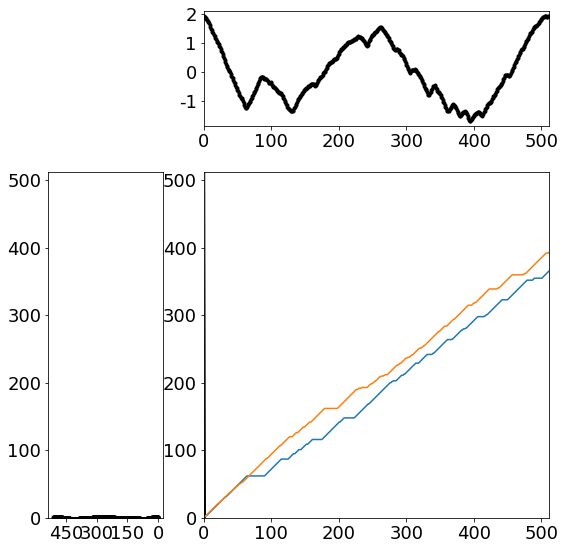

In [ ]:
'''
Plotting
'''
%matplotlib inline
import matplotlib.ticker as tick
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()

# definitions for the axes
left, width = 0.12, 0.60
bottom, height = 0.08, 0.60
bottom_h =  0.16 + width 
left_h = left + 0.27 
rect_plot = [left_h, bottom, width, height]
rect_x = [left_h, bottom_h, width, 0.2]
rect_y = [left, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(2, figsize=(8, 8))

axplot = plt.axes(rect_plot)
axx = plt.axes(rect_x)
axy = plt.axes(rect_y)

# Plot the matrix
axplot.pcolor(path,cmap='gray')
axplot.plot(path)

axplot.set_xlim((0, len(x_train[0])))
axplot.set_ylim((0, len(x_train[1])))
axplot.tick_params(axis='both', which='major', labelsize=18)

# Plot time serie horizontal
axx.plot(x_train[0],'.', color='k')
axx.tick_params(axis='both', which='major', labelsize=18)
xloc = plt.MaxNLocator(4)
x2Formatter = tick.FormatStrFormatter('%d')
axx.yaxis.set_major_locator(xloc)
axx.yaxis.set_major_formatter(x2Formatter)

# Plot time serie vertical
axy.plot(x_train[1],'.',color='k')
axy.invert_xaxis()
yloc = plt.MaxNLocator(4)
xFormatter = tick.FormatStrFormatter('%d')
axy.xaxis.set_major_locator(yloc)
axy.xaxis.set_major_formatter(xFormatter)
axy.tick_params(axis='both', which='major', labelsize=18)

#Limits
axx.set_xlim(axplot.get_xlim())
axy.set_ylim(axplot.get_ylim())

plt.show()

In [ ]:
path[0:20]

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17),
 (17, 18),
 (18, 19)]

Text(0.5, 1.0, 'DTW Distance')

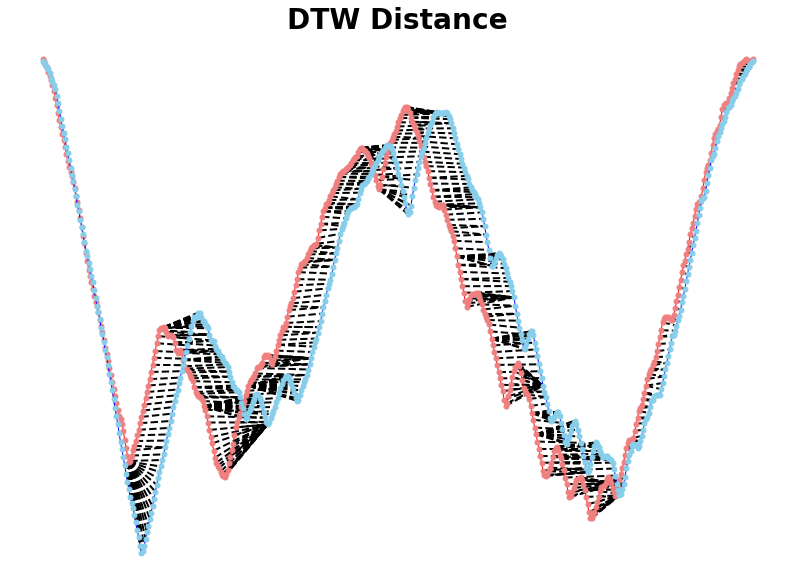

In [ ]:
fig, ax = plt.subplots(figsize=(14, 10))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in path:
    ax.plot([map_x, map_y], [x_train[0][map_x], x_train[1][map_y]], '--k', linewidth=2)

ax.plot(x_train[0], '-ro', label='x', linewidth=1, markersize=5, markerfacecolor='lightcoral', markeredgecolor='lightcoral')
ax.plot(x_train[1], '-bo', label='y', linewidth=1, markersize=5, markerfacecolor='skyblue', markeredgecolor='skyblue')
ax.set_title("DTW Distance", fontsize=28, fontweight="bold")

#fig.savefig("ex1_dtw_distance.png", **savefig_options)

(array([  0,   0,   1, ..., 686, 687, 687]),
 array([0, 1, 0, ..., 1, 0, 1]),
 array([0, 0, 0, ..., 0, 0, 0]))

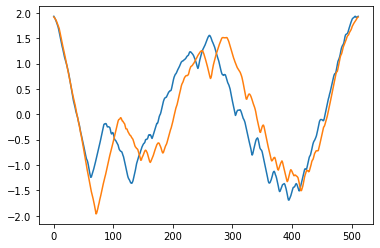

In [ ]:
plt.plot(x_train[0])
plt.plot(x_train[1])

In [ ]:
print(x_train[0][path][600])
print(x_train[1][path][600])

tensor([[-0.6447],
        [-0.2064]], dtype=torch.float64)
tensor([[-0.9064],
        [-0.6719]], dtype=torch.float64)


# Mix up part

In [ ]:
device = torch.device("cpu")

def prepare_data(datasets_dict, dataset_name):
    x_train = datasets_dict[dataset_name][0]
    y_train = datasets_dict[dataset_name][1]
    x_test = datasets_dict[dataset_name][2]
    y_test = datasets_dict[dataset_name][3]

    nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))

    # make the min to zero of labels
    y_train, y_test = transform_labels(y_train, y_test)

    # save orignal y because later we will use binary
    y_true = y_test.astype(np.int64)
    y_true_train = y_train.astype(np.int64)
    # transform the labels from integers to one hot vectors
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
    y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    
    if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        x_train = np.array(x_train)
        x_test = np.array(x_test)
    
    x_train = torch.from_numpy(x_train)
    x_test = torch.from_numpy(x_test)
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)
    y_true = torch.from_numpy(y_true)

    
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_true, y_test)
    train_dataloader = DataLoader(train_dataset, batch_size= 64, shuffle=True, num_workers= 0)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers= 0)
   
    return train_dataloader, test_dataloader, nb_classes, y_true, enc

use_cuda = torch.cuda.is_available()
def mixup_data(x, y, alpha=0.4, use_cuda=False):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index, :]
    
    return mixed_x, mixed_y

In [ ]:
def jitter(x, sigma=0.08):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)


In [ ]:
archive_name = 'TSC'
datasets_dict = read_all_datasets(root_dir, archive_name)
DATASET_NAMES = ['Herring']
for dataset_name in DATASET_NAMES:
  #x_train, y_train, *_ = prepare_data(datasets_dict, dataset_name)
  train_dataloader, test_dataloader, nb_classes, y_true, enc = prepare_data(datasets_dict, dataset_name)



dataiter = iter(train_dataloader)
ts, labels = dataiter.next()
#x_train.reshape(-1,  x_train[0], x_train[1])
#ts_a = jitter(x_train[0])
ts_a, targets_a = mixup_data(ts, labels, 0.4,use_cuda)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


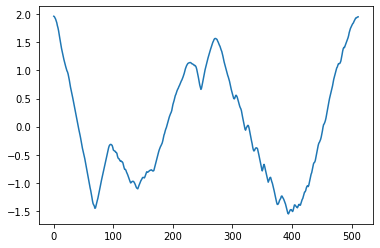

In [ ]:
%matplotlib inline
plt.plot(ts[0], label = 'no_augmentation')
#plt.plot(ts_a[0],label = 'with_augmentation')
#plt.legend()
#plt.savefig('/content/gdrive/MyDrive/Inception_time/InceptionTime/results/distaloriginal.png')